# Atmospheric Dispersion Examples

This notebook will demonstrate how to compute the effects of atmospheric refraction for solar observations. 

atmospheric_density: Given temperature, pressure, etc., return atmospheric density (needed for refractivity)

refractivity: Given temperature, pressure, etc., return refractivity (needed for atmospheric_refraction)

atmospheric_refraction: Compute magnitude of refraction and parallactic angle for given wavelengths at given times

offsets: Compute refraction offsets in solar disk NS-EW coordinates

## Load important modules

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm, LogNorm, SymLogNorm
from scipy import interpolate
import astropy.units as u
from astropy import coordinates
from astropy.coordinates import EarthLocation, AltAz, TETE
from astropy.coordinates.erfa_astrom import erfa_astrom, ErfaAstromInterpolator
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
import sunpy as sp
from sunpy import coordinates as coord
import pickle

import atm_dispersion as adm # Atmospheric Dispersion Module

## Example 1: calculate refractivity for a single wavelength

In [2]:
# "average" atmospheric conditions on Haleakala
temp = 11.*u.deg_C
pressure = 71100*u.pascal
humidity = 30.0     # percent
co2 = 380.      # ppm

# wavelength(s) for which refractivity will be computed; in this case, the calcium H line
wavelengths = np.array([396.9])*u.nm

refrac = adm.refractivity(wavelengths,
                          temp,
                          pressure,
                          humidity,
                          co2,
                          verbose=2)

print("Refractivity (n-1) = {:.5g}".format(refrac[0])) # print refractivity to 5 sig. figs.

density a -  0.8670712923452407 1.2254226533684582 0.7075691721234494
density w -  0.003013028303143761 0.009859381090734688 0.30560014623790555
n(axs):  [28291.41881446] 
n(ws):  [318.58190157] 
rho(a/axs):  0.7075691721234494 
rho(w/ws):  0.30560014623790555 
n(prop):  [20115.49446446]
n(air):  [20018.13578875] 
n(water):  [97.35867571]
Refractivity (n-1) = 0.00020115


## Example 2: compute atmospheric refraction for a range of wavelengths at a single time

In [3]:
# First, we need to define our observing location

# Default will be to use DKIST as the location
# but any other location could be used by manually setting the geodetic coordinates

set_location_dkist = True

if set_location_dkist:
    observing_loc = EarthLocation.of_site('dkist')
    observing_loc.info.meta['name'] = 'DKIST'
    # these are the average atmospheric conditions on Haleakalā
    atm_conditions = {
        'temp': 8.2*u.deg_C,
        'pressure': 70965.*u.Pa,
        'humidity': 30,
        'co2_conc': 400}

else:
    longitude =    -156.25*u.deg
    latitude  =     20.71*u.deg
    altitude  =     0.*u.m
    observing_loc = EarthLocation(lat=latitude, lon=longitude, height=altitude)
    # these are the conditions for the standard atmosphere
    atm_conditions = {'temp':15*u.deg_C, 'pressure':101325.*u.Pa, 'humidity':0, 'co2_conc':314}

print("Observing Location -- longitude: {:0.4f} ; latitude: {:0.4f} ; altitude: {:0.0f} "\
      .format(observing_loc.geodetic.lon, observing_loc.geodetic.lat, observing_loc.geodetic.height))


Observing Location -- longitude: -156.2564 deg ; latitude: 20.7067 deg ; altitude: 3067 m 


Text(0.5, 1.0, 'Total Atmosphere Refraction')

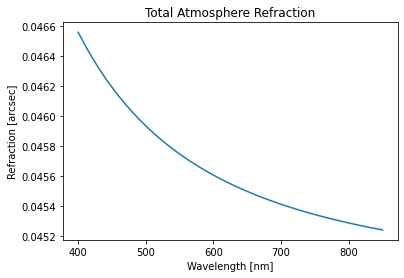

In [4]:
# This section calculates the absolute refraction 

# series of wavelengths, ranging from 400 to 850 nm
wavelengths = (np.arange(46)*10 + 400)*u.nm

# time for which refraction will be computed; note that Hawaii time is UTC-10
#time = Time('2021-05-23 17:00:00', scale='utc') + np.zeros((1))

# at this time the Sun is nearly at the zenith
time = Time('2021-05-23 22:21:40',scale='utc') + np.zeros((1))

time.format = 'jd'

# Compute dispersion for given times and wavelengths
refraction = adm.atmospheric_refraction(wavelengths,
                                        time,
                                        air_pressure=atm_conditions['pressure'],
                                        air_temp=atm_conditions['temp'], 
                                        humidity=atm_conditions['humidity'],
                                        co2_conc=atm_conditions['co2_conc'],
                                        observer_location=observing_loc,
                                        verbose=0)

# Plot refraction as a function of wavelength
plt.plot(wavelengths.value, refraction[0]['refraction_mag (arcsec)'][0])

plt.xlabel('Wavelength [nm]')
plt.ylabel('Refraction [arcsec]')
plt.title('Total Atmosphere Refraction')



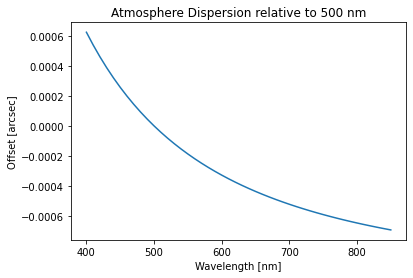

In [5]:
# Now let's calculate the dispersion, the relative difference in refraction between two different wavelengths

ref_wave = (np.zeros(len(wavelengths)) + 5000*u.AA)

idx_500nm = np.argmin(abs(wavelengths - ref_wave))
refraction_abs = refraction[0]['refraction_mag (arcsec)']

dispersion_ref500nm = refraction_abs - refraction_abs[0, idx_500nm]

plt.plot(wavelengths.value, dispersion_ref500nm[0,:])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Offset [arcsec]')
plt.title('Atmosphere Dispersion relative to {:n}'.format(ref_wave[0].to(u.nm)))

max_dispersion = np.max(dispersion_ref500nm)


## Example 3: compute dispersion-induced offsets in solar NS-EW coordinates

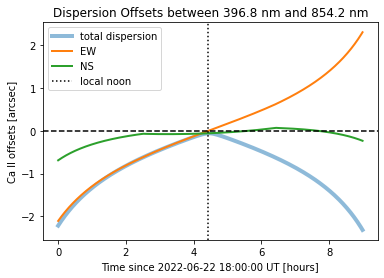

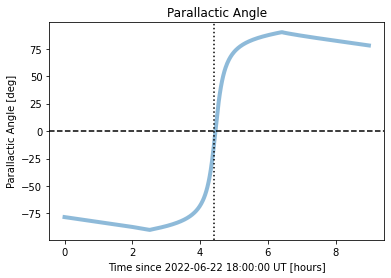

In [6]:
# Choose two wavelengths: we'll use the calcium lines at 397 and 854 nm
wavelengths = np.array([396.8, 854.2]) * u.nm

# We'll use the same location, but this time we'll calculate how the values change over several hours.
# Again, note that Hawaii time is UTC-10, so e.g. 18:00 UTC is 08:00 a.m. in Hawaii.
times = Time('2022-06-22 18:00:00', scale='utc') + np.arange(60*9)*u.min
times.format = 'jd'
noon_idx = int(np.where(np.modf((times - 10*u.hour).value)[0] == 0)[0][0]
               + (15 - observing_loc.geodetic.lon.value % 15)*4)

# Compute offsets
(offsets, refraction_atm, coords) = adm.offsets(wavelengths,
                                        times,
                                        air_pressure=atm_conditions['pressure'],
                                        air_temp=atm_conditions['temp'],
                                        humidity=atm_conditions['humidity'],
                                        co2_conc=atm_conditions['co2_conc'], 
                                        observer_location=observing_loc,
                                        verbose=0)

dispersion_relative = ((refraction_atm['refraction_mag (arcsec)'])[:,1]
                       - (refraction_atm['refraction_mag (arcsec)'])[:,0])
parallactic_angle   = refraction_atm['parallactic_angle (degrees)']

EW = offsets['East-West']
NS = offsets['North-South']

T_delta = times - times[0]

# Make a plot of total dispersion, and dispersion broken down into solar geocentric coordinates
plt.figure(1)
plt.plot(T_delta.value*24, dispersion_relative, label='total dispersion', linewidth=4, alpha=0.5)
plt.plot(T_delta.value*24, EW[:,0] - EW[:,1], label='EW', linewidth=2)
plt.plot(T_delta.value*24, NS[:,0] - NS[:,1], label='NS', linewidth=2)

plt.axhline(0, color='k', linestyle='--')
plt.axvline(T_delta[noon_idx].value*24, color='k', linestyle=':', label='local noon')

plt.xlabel('Time since ' + times[0].strftime('%Y-%m-%d %H:%M:%S') + ' UT [hours]')
plt.ylabel('Ca II offsets [arcsec]')
plt.title('Dispersion Offsets between {:0.1f} and {:0.1f}'.format(wavelengths[0], wavelengths[1]))
plt.legend()

# Now make a plot of parallactic angle (which is wavelength independent)
plt.figure(2)
plt.plot(T_delta.value*24, parallactic_angle, label='parallactic angle', linewidth=4, alpha=0.5)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(T_delta[noon_idx].value*24, label='local noon', color='k', linestyle=':')

plt.xlabel('Time since ' + times[0].strftime('%Y-%m-%d %H:%M:%S') + ' UT [hours]')
plt.ylabel('Parallactic Angle [deg]')
plt.title('Parallactic Angle')

noon_values = (dispersion_relative[noon_idx], parallactic_angle[noon_idx])

## Example 4: given a series of times, compute dispersion for multiple wavelengths

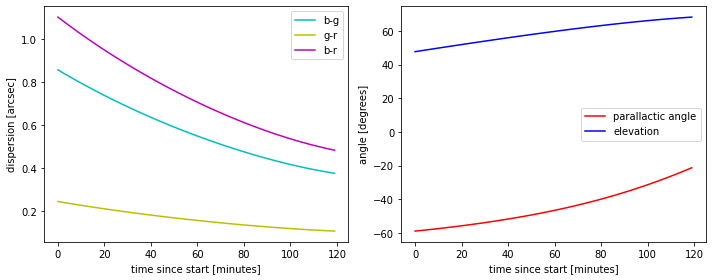

In [7]:
# Suppose you know at what times you observed the Sun, and you want to calculate
# the dispersion between multiple lines for alignment purposes.

# Let's use three spectral lines: Ca II H, Fe I 6301, and Ca II 8542
wavelengths = np.array([396.8, 630.1, 854.2]) * u.nm
nw = wavelengths.size
# Observing for two hours starting at 10 AM Hawaii time
times = Time("2022-03-21 20:00:00", scale='utc') + np.arange(60*2)*u.min
nt = times.size
times.format = 'jd'
# We've already set our location and atmospheric conditions in Example 2, so don't forget to do that!

# Calculate atmospheric refraction
refraction, times, coords = adm.atmospheric_refraction(wavelengths,
                                                       times,
                                                       air_pressure=atm_conditions['pressure'],
                                                       air_temp=atm_conditions['temp'], 
                                                       humidity=atm_conditions['humidity'],
                                                       co2_conc=atm_conditions['co2_conc'],
                                                       observer_location=observing_loc,
                                                       verbose=0)

# Now we can get the dispersion by taking the difference of consecutive wavelengths.
# This gives two of the three combinations; the third is simply the sum of the others.
dispersion = -np.diff(refraction['refraction_mag (arcsec)'], axis=1)
par_ang = refraction['parallactic_angle (degrees)']

# Okay, let's take a look at how the dispersion changes over time.
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot((times - times[0]).value*1440, dispersion[:,0], '-c', label='b-g')
plt.plot((times - times[0]).value*1440, dispersion[:,1], '-y', label='g-r')
plt.plot((times - times[0]).value*1440, np.sum(dispersion, axis=1), '-m', label='b-r')
plt.xlabel('time since start [minutes]')
plt.ylabel('dispersion [arcsec]')
plt.legend()
plt.subplot(122)
plt.plot((times - times[0]).value*1440, par_ang, '-r', label='parallactic angle')
plt.plot((times - times[0]).value*1440, coords['altitude (degrees)'], '-b', label='elevation')
plt.xlabel('time since start [minutes]')
plt.ylabel('angle [degrees]')
plt.legend()
plt.tight_layout()

## Example 5: given coordinates, compute dispersion

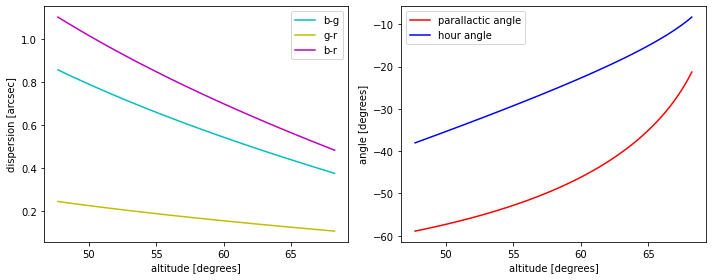

In [8]:
# We can also use the coordinates directly; in this case, we'll use altitude and azimuth.
# This is particularly time-efficient if you're working with massive datasets.
# For the purpose of illustration, let's use the coordinates from the previous example.
altitude = coords['altitude (degrees)']
azimuth = coords['azimuth (degrees)']

# Calculate atmospheric refraction
refraction, times, coords = adm.atmospheric_refraction(wavelengths,
                                                       times,
                                                       input_alt=altitude,
                                                       input_az=azimuth,
                                                       air_pressure=atm_conditions['pressure'],
                                                       air_temp=atm_conditions['temp'], 
                                                       humidity=atm_conditions['humidity'],
                                                       co2_conc=atm_conditions['co2_conc'],
                                                       observer_location=observing_loc,
                                                       verbose=0)
dispersion = -np.diff(refraction['refraction_mag (arcsec)'], axis=1)
par_ang = refraction['parallactic_angle (degrees)']

# Let's see how the dispersion varies with altitude this time.
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(altitude, dispersion[:,0], '-c', label='b-g')
plt.plot(altitude, dispersion[:,1], '-y', label='g-r')
plt.plot(altitude, np.sum(dispersion, axis=1), '-m', label='b-r')
plt.xlabel('altitude [degrees]')
plt.ylabel('dispersion [arcsec]')
plt.legend()
plt.subplot(122)
plt.plot(altitude, par_ang, '-r', label='parallactic angle')
plt.plot(altitude, coords['hour angle (degrees)'], '-b', label='hour angle')
plt.xlabel('altitude [degrees]')
plt.ylabel('angle [degrees]')
plt.legend()
plt.tight_layout()

## Example 6: compute dispersion and parallactic angle for a full year

In [9]:
# Let's see how the dispersion changes over the entire year of 2022.
times = Time("2022-01-01 10:00:00", scale='utc') + np.arange(1440*365)*u.min
times.format = 'jd'

# We'll look at the dispersion between the Ca II H and Ca II 8542 Å lines.
wavelengths = np.array([396.8, 854.2]) * u.nm

# Warning: this one takes a while, as astropy uses more precise algorithms than IDL.
# Also because 1440*365 is a really big number.
refraction, times, coords = adm.atmospheric_refraction(wavelengths,
                                                       times,
                                                       air_pressure=atm_conditions['pressure'],
                                                       air_temp=atm_conditions['temp'], 
                                                       humidity=atm_conditions['humidity'],
                                                       co2_conc=atm_conditions['co2_conc'],
                                                       observer_location=observing_loc,
                                                       verbose=0)

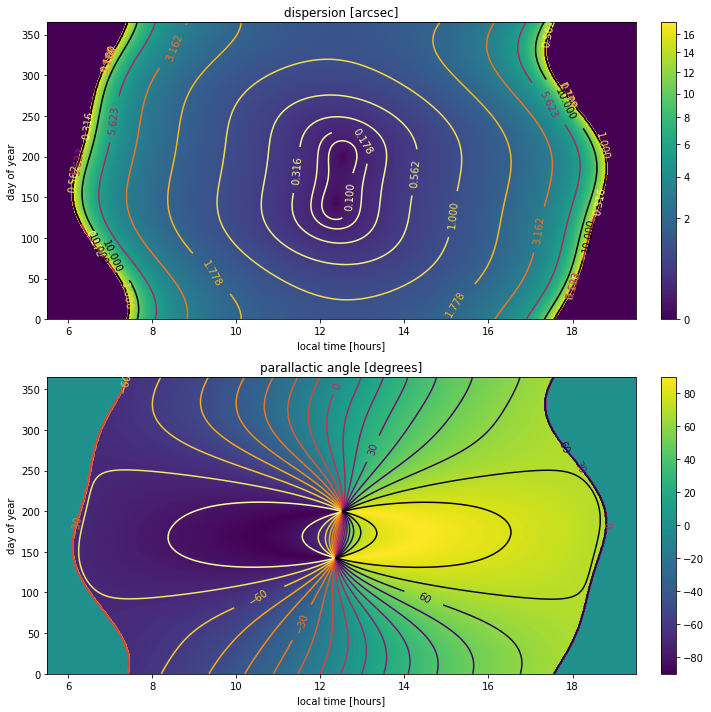

In [48]:
# Reshape the data into a 2-D array so we can plot it as images.
dispersion = -np.diff(refraction['refraction_mag (arcsec)'], axis=1).reshape((365, 1440))
par_ang = refraction['parallactic_angle (degrees)'].reshape((365, 1440))

# Mask out times where the sun is below 4 degrees.
mask = np.where(coords['altitude (degrees)']>4, 1, 0).reshape((365, 1440))

# Okay, let's plot the data!
fig,ax = plt.subplots(2, 1, figsize=(10, 10))
im_disp = ax[0].imshow(dispersion*mask, aspect='auto', origin='lower',
                       extent=[0, 24, 0, 365], norm=PowerNorm(0.5))
plt.colorbar(im_disp, ax=ax[0], fraction=0.046, pad=0.04)
# We'll add some contours to highlight how the dispersion changes.
cont_disp = ax[0].contour(dispersion*mask, levels=10**(np.arange(9)*0.25 - 1),
                        extent=[0, 24, 0, 365], cmap='inferno_r')
ax[0].clabel(cont_disp, cont_disp.levels, inline=True)
ax[0].set_xlim(5.5, 19.5)
ax[0].set_xlabel('local time [hours]')
ax[0].set_ylabel('day of year')
ax[0].set_title('dispersion [arcsec]')

im_parang = ax[1].imshow(par_ang*mask, aspect='auto', origin='lower', extent=[0, 24, 0, 365])
plt.colorbar(im_parang, ax=ax[1], fraction=0.046, pad=0.04)
# Some contours for the parallactic angle.
# Note the two points where the contours intersect; these are the days on which
# the sun passes directly overhead at Haleakalā, known locally as "Lahaina Noon."
cont_parang = ax[1].contour(par_ang*mask, levels=np.arange(17)*10 - 80,
                        extent=[0, 24, 0, 365], cmap='inferno_r')
ax[1].clabel(cont_parang, cont_parang.levels[2::3], inline=True)
ax[1].set_xlim(5.5, 19.5)
ax[1].set_xlabel('local time [hours]')
ax[1].set_ylabel('day of year')
ax[1].set_title('parallactic angle [degrees]')

plt.tight_layout()

## Bonus: running the module as a script computes optimal slit angles

When observing the sun with a slit spectrograph, the slit must rotate during the scan to remain fixed on the same celestial coordinates. So long as the "images" of the slit at different wavelengths remain aligned within one slit width, the data at those wavelengths can be considered cospatial. By selecting the optimal initial slit orientation, such that it rotates through the parallactic angle, this cospatiality can be maintained for longer periods, with the largest gains seen when the sun is near the zenith, where the parallactic angle changes most rapidly.

In [54]:
# Script output is stored as a structure in a pickle file.
with open('refraction.calc.haleakala.08.11.2021.pkl', 'rb') as f:
    data = pickle.load(f)
# Let's see what data are stored in this structure.
data.keys()

dict_keys(['times_all_hka_2d', 'hours_ut_hka', 'wavelengths', 'alt_hka_2d', 'az_hka_2d', 'ha_hka_2d', 'parang_hka', 'dispersion_hka', 'time_available_hka', 'time_available_hka_rot', 'time_available_hka_opt'])

In [55]:
# Check for what wavelengths dispersion was computed.
data['wavelengths']

<Quantity [ 400.,  525.,  630.,  700.,  850., 1083., 1525.] nm>

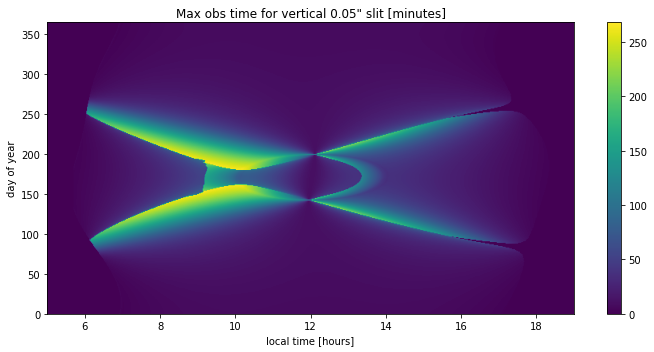

In [96]:
# Let's use the same two calcium lines as before, at about 400 and 850 nm.
# This is hard-coded into the script; look for "parashift_hka_caII" near the end.
# Feel free to try changing the chosen wavelengths and rerunning the script.

# If the slit is initially vertical and rotates to track the sun,
# this is how long cospatial observations can be obtained for a 0.05" slit.
plt.figure(figsize=(10,5))
plt.imshow(data['time_available_hka'], origin='lower', aspect='auto', extent=[0, 24, 0, 365])
plt.xlim(5, 19)
plt.colorbar()
plt.xlabel('local time [hours]')
plt.ylabel('day of year')
plt.title('Max obs time for vertical 0.05" slit [minutes]')
plt.tight_layout()

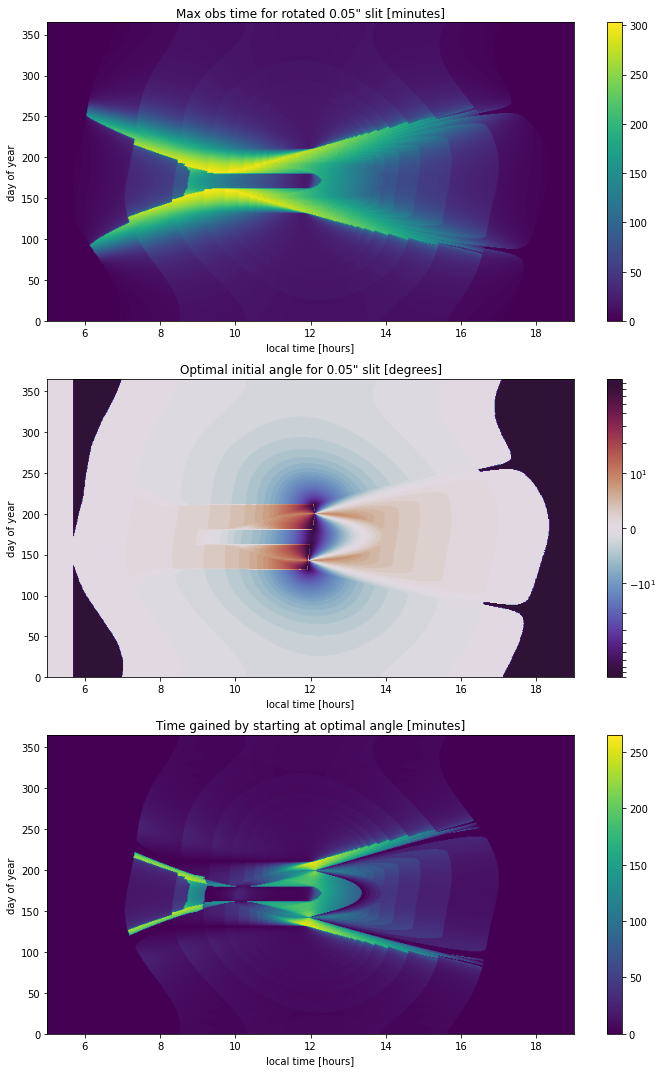

In [97]:
# By starting at a different angle and rotating through the parallactic angle,
# this is how long the observations can last.
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
im_opt = ax[0].imshow(data['time_available_hka_opt'][:, :, 0],
                       origin='lower', aspect='auto', extent=[0, 24, 0, 365])
ax[0].set_xlim(5, 19)
plt.colorbar(im_opt, ax=ax[0])
ax[0].set_xlabel('local time [hours]')
ax[0].set_ylabel('day of year')
ax[0].set_title('Max obs time for rotated 0.05" slit [minutes]')
im_ang = ax[1].imshow(data['time_available_hka_opt'][:, :, 1], cmap='twilight_shifted',
                       origin='lower', aspect='auto', extent=[0, 24, 0, 365], norm=SymLogNorm(10, 0.5))
ax[1].set_xlim(5, 19)
plt.colorbar(im_ang, ax=ax[1])
ax[1].set_xlabel('local time [hours]')
ax[1].set_ylabel('day of year')
ax[1].set_title('Optimal initial angle for 0.05" slit [degrees]')
im_diff = ax[2].imshow(data['time_available_hka_opt'][:, :, 0] - data['time_available_hka'],
                       origin='lower', aspect='auto', extent=[0, 24, 0, 365])
ax[2].set_xlim(5, 19)
plt.colorbar(im_diff, ax=ax[2])
ax[2].set_xlabel('local time [hours]')
ax[2].set_ylabel('day of year')
ax[2].set_title('Time gained by starting at optimal angle [minutes]')
plt.tight_layout()